# Image Classification with DNN

## DATASETS:
(a) Carbonic Anhydrase II (ChEMBL205), a protein lyase,  
(b) Cyclin-dependent kinase 2 (CHEMBL301), a protein kinase,  
(c) ether-a-go-go-related gene potassium channel 1 (HERG) (CHEMBL240), a voltage-gated ion channel,  
(d) Dopamine D4 receptor (CHEMBL219), a monoamine GPCR,  
(e) Coagulation factor X (CHEMBL244), a serine protease,  
(f) Cannabinoid CB1 receptor (CHEMBL218), a lipid-like GPCR and  
(g) Cytochrome P450 19A1 (CHEMBL1978), a cytochrome P450.  
The activity classes were selected based on data availability and as representatives of therapeutically important target classes or as anti-targets.

In [65]:
!nvidia-smi

Wed Nov 24 12:16:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0  On |                  N/A |
| 61%   58C    P2    52W / 240W |   3810MiB /  8116MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [28]:
#%%capture
#!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
#!chmod +x Miniconda3-latest-Linux-x86_64.sh
#!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
#!time conda install -q -y -c conda-forge rdkit

In [29]:
# Import
import pandas as pd
import numpy as np
from pathlib import Path

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem
from rdkit.Chem import AllChem

In [31]:
dataset = 'CHEMBL205_cl'

In [32]:
path = Path('../dataset/13321_2017_226_MOESM1_ESM/')
df = pd.read_csv(path/f'{dataset}_ecfp_1024.csv')

In [33]:
list(path.iterdir())

[PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL1978_cl_ecfp_1024.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL205_cl-data-with-ecfp-activations.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL244_cl_ecfp_512.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL218_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/RdkitDescriptors.py'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL205_cl_ecfp_512.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL301_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL205_cl_ecfp_1024.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL1978_cl_ecfp_512.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL240_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL301_cl_ecfp_512.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL218_cl_ecfp_1024.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL301_cl_ecfp_1024.cs

In [34]:
DATA = path/'mol_images'

In [35]:
IMAGES = DATA/dataset

# Create train validation split

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
x_train, x_valid = train_test_split(df.index, test_size=0.2, random_state=666, stratify=df['Activity'])
df.loc[x_train, 'is_valid']=False
df.loc[x_valid, 'is_valid']=True

In [38]:
df.is_valid.value_counts()

False    14352
True      3589
Name: is_valid, dtype: int64

# Create dataloader

In [39]:
from fastai.vision.all import *

In [40]:
df['Image'] = df['CID'] + '.png'
df.head()

,CID,SMILES,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,ECFP4_8,...,ECFP4_1018,ECFP4_1019,ECFP4_1020,ECFP4_1021,ECFP4_1022,ECFP4_1023,ECFP4_1024,Activity,is_valid,Image
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,False,CHEMBL188002.png
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,False,CHEMBL364127.png
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,False,CHEMBL1683469.png
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,False,CHEMBL52564.png
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,False,CHEMBL21427.png


In [41]:
images = df['CID'] + ".png"
images.head()

0     CHEMBL188002.png
1     CHEMBL364127.png
2    CHEMBL1683469.png
3      CHEMBL52564.png
4      CHEMBL21427.png
Name: CID, dtype: object

In [42]:
# No flips, some rotation and zoom. Normalize to imagenet_stats as
# we're using pretrained models.
batch_tfms = [*aug_transforms(mult=1.0, do_flip=False, flip_vert=False, 
               max_rotate=20.0, min_zoom=1.0, max_zoom=1.1, max_lighting=0., 
               max_warp=0., p_affine=0.75, p_lighting=0.75, xtra_tfms=None, 
               size=224, mode='bilinear', 
               pad_mode='border', align_corners=True, 
               batch=False, min_scale=1.0), 
              Normalize.from_stats(*imagenet_stats)]

In [43]:
db = DataBlock(
    blocks = (ImageBlock(), CategoryBlock()), 
    get_x=ColReader('Image', pref=IMAGES),
    get_y=ColReader('Activity'), 
    splitter=ColSplitter('is_valid'),
    item_tfms=None, 
    batch_tfms=batch_tfms,
    )

In [44]:
def get_df(dataset, random_state=42, test_size=0.2):
    df = pd.read_csv(path/f'{dataset}.csv')
    x_train, x_valid = train_test_split(df.index, test_size=0.2, random_state=random_state, stratify=df['Activity'])
    df.loc[x_train, 'is_valid']=False
    df.loc[x_valid, 'is_valid']=True
    df['Image'] = df['CID'] + '.png'
    return df

In [45]:
def get_df_with_clusters(dataset, n_clusters=100, random_state=42, test_size=0.2):
    df = pd.read_csv(path/f'{dataset}_ECFP_1024_with_{n_clusters}_clusters.csv')
    values = df.Cluster.value_counts(ascending=True)
    values = values[values < 2].index
    for i in list(values):
        df = df.drop(df[df.Cluster == i].index)
    df.reset_index(drop=True, inplace=True)
    x_train, x_valid = train_test_split(df.index, test_size=test_size, random_state=random_state, stratify=df['Cluster'])
    df.loc[x_train, 'is_valid']=False
    df.loc[x_valid, 'is_valid']=True
    df['Image'] = df['Name'] + '.png'
    return df

In [46]:
df = get_df_with_clusters(dataset)
df.head()

,Name,SMILES,Cluster,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,ECFP4_1018,ECFP4_1019,ECFP4_1020,ECFP4_1021,ECFP4_1022,ECFP4_1023,ECFP4_1024,Activity,is_valid,Image
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,28,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,False,CHEMBL188002.png
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,28,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,False,CHEMBL364127.png
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,93,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,True,CHEMBL1683469.png
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],14,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,False,CHEMBL52564.png
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,32,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,True,CHEMBL21427.png


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17928 entries, 0 to 17927
Columns: 1030 entries, Name to Image
dtypes: int64(1026), object(4)
memory usage: 140.9+ MB


In [48]:
IMAGES = DATA/dataset
IMAGES

Path('../dataset/13321_2017_226_MOESM1_ESM/mol_images/CHEMBL205_cl')

In [49]:
def get_dls(dataset, bs=64, clustering=False, random_state=42):
    IMAGES = DATA/dataset
    if clustering:
        df = get_df_with_clusters(dataset, n_clusters=100)
    else: 
        df = get_df(dataset)
    db = DataBlock(
        blocks = (ImageBlock(), CategoryBlock()), 
        get_x=ColReader('Image', pref=IMAGES),
        get_y=ColReader('Activity'), 
        splitter=ColSplitter('is_valid'),
        item_tfms=None, 
        batch_tfms=None,
        )
    dls = db.dataloaders(df, bs=bs, shuffle_train=True, random_state=42)
    return dls, df

In [50]:
dls, _ = get_dls(dataset, clustering=True)

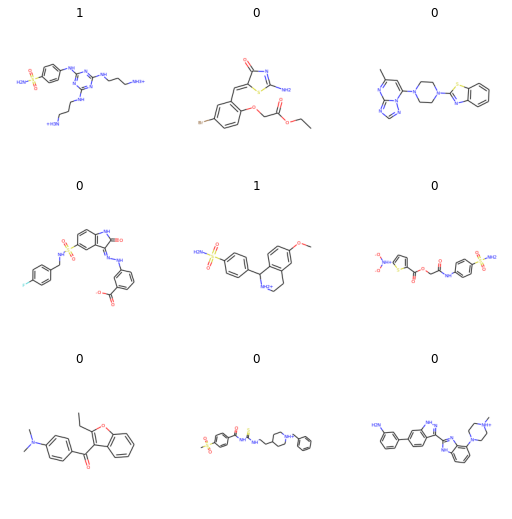

In [51]:
dls.show_batch()

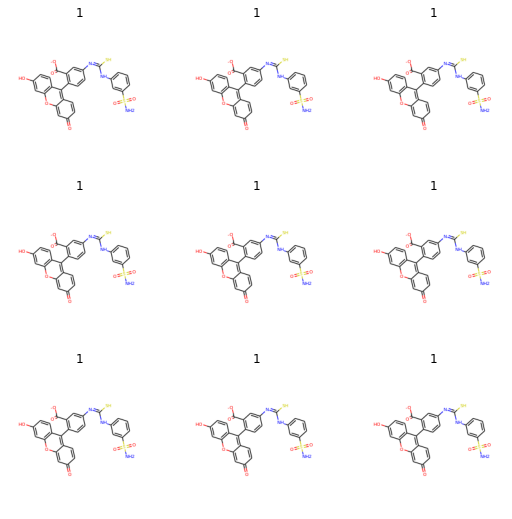

In [52]:
dls.show_batch(unique=True)

# Create class weights

In [53]:
TARGET = 'Activity'

In [54]:
class_count_df = df.groupby(TARGET).count()
class_count_df

,Name,SMILES,Cluster,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,ECFP4_1017,ECFP4_1018,ECFP4_1019,ECFP4_1020,ECFP4_1021,ECFP4_1022,ECFP4_1023,ECFP4_1024,is_valid,Image
Activity,,,,,,,,,,,,,,,,,,,,,
0,16298,16298,16298,16298,16298,16298,16298,16298,16298,16298,...,16298,16298,16298,16298,16298,16298,16298,16298,16298,16298
1,1630,1630,1630,1630,1630,1630,1630,1630,1630,1630,...,1630,1630,1630,1630,1630,1630,1630,1630,1630,1630


In [55]:
n_0, n_1 = class_count_df.iloc[0, 0], class_count_df.iloc[1, 0]

In [56]:
w_0 = (n_0 + n_1) / (2.0 * n_0)
w_1 = (n_0 + n_1) / (2.0 * n_1)
w_0, w_1

(0.5500061357221745, 5.499386503067485)

In [57]:
class_weights=torch.FloatTensor([w_0, w_1]).cuda()

In [58]:
loss_func = CrossEntropyLossFlat(weight=class_weights)

In [59]:
def get_loss_func(df):
    TARGET = 'Activity'
    class_count_df = df.groupby(TARGET).count()
    n_0, n_1 = class_count_df.iloc[0, 0], class_count_df.iloc[1, 0]
    w_0 = (n_0 + n_1) / (2.0 * n_0)
    w_1 = (n_0 + n_1) / (2.0 * n_1)
    class_weights=torch.FloatTensor([w_0, w_1]).cuda()
    loss_func = CrossEntropyLossFlat(weight=class_weights)
    return loss_func

In [60]:
loss_func=get_loss_func(df)

# Train CNN model

In [61]:
from sklearn.metrics import auc,roc_auc_score,recall_score,precision_score,f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

In [62]:
from fastai.callback.hook import *

In [63]:
def train_model(dls, arch=resnet18, loss_func=None, epochs=16, wd=None, lr=None):
    
    
    print(f'Architechture: {arch}')
    #print(f'Untrained epochs: freeze_epochs={freeze_epochs}')
    print(f'Trained epochs: epochs={epochs}')
    print(f'Weight decay: wd={wd}')
    learn = cnn_learner(dls, arch=arch, pretrained=True, 
                            wd=wd,
                            loss_func=loss_func,
                            metrics=[accuracy, 
                            F1Score(), 
                            Precision(), 
                            Recall(), 
                            RocAucBinary(), 
                            MatthewsCorrCoef()])
    
    if lr == None: 
        print(f'Finding learning rate...')
        lr_min, lr_steep = learn.lr_find(suggestions=True, show_plot=False)
        print(f'Training model with learning rate: {lr_min}')
        lr = lr_min
    else: 
        print(f'Training model with learning rate: {lr}')
    learn.fine_tune(epochs, lr)
    
    return learn

In [64]:
# Train model on resnet18
learn = train_model(dls, epochs=16, lr=3e-3, wd=0.002)

Architechture: <function resnet18 at 0x7fd5fc0d87b8>
Trained epochs: epochs=16
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.304809,0.188893,0.939208,0.636667,0.679715,0.598746,0.912461,0.605087,00:33


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time


KeyboardInterrupt: 

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(k=50)

# Test different regularizations

## Results:
### wd = 0.002 is good for around 15-20 epochs before overfitting
### lr = 3e-3 is good for most CNNs and also in this case
### dropout = 0.5 is a usually sustainable

In [ ]:
from sklearn.model_selection import ParameterGrid

In [ ]:
# wd = 0.002 works for around 15-20 epochs
# lr = 3e-3 is good most CNN and in this case
# dropout = 0.5 is a usually sustainable
# batch_size = 64
param_grid={
    "bs" : [128, 252, 512],
}
param_grid = ParameterGrid(param_grid)

for p in param_grid:
    dls = get_dls(dataset, bs=p['bs'])
    learn = train_model(dls, loss_func=loss_func, epochs=15, wd=0.002, lr=3e-3)

# Test random state

**Results:** Random state has a huge impact \
**Tip:** Try clustering methods

In [ ]:
random_states = [1,4,42,666]

In [ ]:
for r in random_states:
    dls = get_dls(dataset, df, random_state=r)
    learn = train_model(dls, epochs=10, lr=3e-3)

# Compare architechtures

**Results:** Not much difference between **Resnet18, Resnet34 and Resnet50** on (224, 224) size images. \
**Alexnet** got worse results then **resnet**. \
Reason could be that the extra layers is not much of a use in this case (i.e. The images does not contain a lot of details) \
**Resnet18** takes less time to train due to less layers and therefore should be used in this case. 

In [ ]:
archs =  [resnet18, resnet50, alexnet]

In [ ]:
for arch in archs:
    train_model(dls, arch=arch, epochs=15, lr=3e-3)

# Test clustering

In [ ]:
def train_on_dataset(dataset, clustering = False):
    print(f'Training model on dataset: {dataset}')
    dls, df = get_dls(dataset, clustering=clustering)
    loss_func = get_loss_func(df)
    learn = train_model(dls, epochs = 10, lr=3e-3, loss_func=loss_func)

    return learn

In [ ]:
learn = train_on_dataset(dataset, clustering=True)

In [ ]:
learn2 = train_on_dataset(dataset)

# Train on all datasets and store model

In [ ]:
datasets = ['CHEMBL205_cl',  'CHEMBL301_cl',  
            'CHEMBL240_cl', 'CHEMBL219_cl', 
            'CHEMBL244_cl', 'CHEMBL218_cl',
           'CHEMBL1978_cl',]

In [ ]:
top_mcc_scores = {
    
    'CHEMBL205': 0.862,
    'CHEMBL301': 0.926,
    'CHEMBL240': 0.884,
    'CHEMBL219': 0.887,
    'CHEMBL244': 0.983,
    'CHEMBL218': 0.941,
    'CHEMBL1978': 0.904}

In [ ]:
def train_on_dataset(dataset, clustering = False):
    print(f'Training model on dataset: {dataset}')
    dls, df = get_dls(dataset, clustering=clustering)
    loss_func = get_loss_func(df)
    learn = train_model(dls, epochs = 20, lr=3e-3, loss_func=loss_func)

    return learn

In [ ]:
learn = train_on_dataset(datasets[0])
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(k=25)
learn.export(fname= f'models/{datasets[0]}')

In [ ]:
for dataset in datasets[4:-1]: 
    learn = train_on_dataset(dataset)
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix()
    interp.plot_top_losses(k=5)
    learn.export(fname= f'models/{dataset}.pkl')

# Transfer learning

### Idea: Create a model that performs good on all datasets after a couple of epochs

In [ ]:
datasets = ['CHEMBL205_cl',  'CHEMBL301_cl',  
            'CHEMBL240_cl', 'CHEMBL219_cl', 
            'CHEMBL244_cl', 'CHEMBL218_cl',
           'CHEMBL1978_cl',]

In [ ]:
learn = train_on_dataset(datasets[0])

In [ ]:
dls = get_dls(datasets[0])

In [ ]:
loss_func=get_loss_func(get_df(datasets[0]))

In [ ]:
learn = cnn_learner(dls, arch=resnet18, pretrained=True,
                        loss_func=loss_func,
                        metrics=[accuracy, 
                        F1Score(), 
                        Precision(), 
                        Recall(), 
                        RocAucBinary(), 
                        MatthewsCorrCoef()])

In [ ]:
lr_min, _ = learn.lr_find(suggestions=True)

In [ ]:
learn.fine_tune(10, lr_min)

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.recorder.plot_sched()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(k=10)

In [ ]:
dls = get_dls(datasets[1])

In [ ]:
learn.dls = dls

In [ ]:
lr_min, _ = learn.lr_find(suggestions=True)

In [ ]:
learn.fine_tune(8, lr_min, freeze_epochs=3)

In [ ]:
learn.recorder.plot_loss()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(k=10)

In [ ]:
dls = get_dls(datasets[3])
learn.dls = dls

In [ ]:
lr_min, _ = learn.lr_find(suggestions=True, show_plot=False)
learn.fine_tune(10, lr_min)

In [ ]:
learn.fine_tune(10, 3e-3)

In [ ]:
def fine_tune_on_data(dataset, learn=None, epochs=2, lr=None):
    df = get_df(dataset)
    dls = get_dls(dataset, df)
    loss_func = get_loss_func(df)
    if learn == None:
        learn = train_model(dls, epochs=epochs, loss_func=loss_func, lr=lr)
    else:
        learn = train_model(dls, arch=learn, epochs=epochs, loss_func=loss_func, lr=lr)
    return learn

In [ ]:
learn = fine_tune_on_data(datasets[0], epochs=2, lr=3e-3)
learn

In [ ]:
learn = fine_tune_on_data(datasets[1], learn, epochs=2, lr=3e-3)
learn